<a href="https://colab.research.google.com/github/Dyl-cmyk/datascience/blob/Assignments-Due/DylaLaurU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 4 Project: Using Hierarchies to Account for Dependence Between Groups



##Intro/Comments

I Decided to use data from fantasy football leagues to figure out average scoring habits of every position. Scores for every position are calculated differently with more emphasis on complete passes for recievers, yards for running backs, touch downs for quarter backs etc. My goal for this project was to see what part of your team produces the most amout of points on a consistent basis.

I took data from

 https://fantasy.nfl.com/research/scoringleaders?position=1#researchScoringLeaders=researchScoringLeaders%2C%2Fresearch%2Fscoringleaders%253Fposition%253D8%2526statCategory%253Dstats%2526statSeason%253D2024%2526statType%253DseasonStats%2526statWeek%253D10%2Creplace

At the end of week 9 (11/6/2024)
This is halfway through the regular season, so many of the "variances" or weirdness from the begenning of the season should be ironed out

##Coding Begins

###Clutter

In [ ]:
!pip install "preliz[full,notebook]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import preliz as pz

##Step 1 Importing, Wrangaling, and intexing data

In [ ]:
#Importing the data for fantasy points
url_fpoint = 'https://raw.githubusercontent.com/Dyl-cmyk/datascience/refs/heads/main/Unit%204%20Project%20Data%20-%20Sheet1.csv'
fantasy_data = pd.read_csv(url_fpoint,dtype={'Position':'category'})

In [ ]:
fantasy_data
#checking to make sure it impored OK

,Player Name,Position,FPoints
0,Lamar Jackson,QB,225.66
1,Baker Mayfield,QB,202.46
2,Jayden Daniels,QB,181.14
3,Josh Allen,QB,181.14
4,Joe Burrow,QB,177.46
...,...,...,...
140,Philadelphia Eagles,DEF,50.00
141,Tampa Bay Buccaneers,DEF,48.00
142,Baltimore Ravens,DEF,48.00
143,Cincinagtti Bengals,DEF,41.00


(array([16., 36., 11., 24., 24., 21.,  4.,  5.,  3.,  1.]),
 array([ 41.   ,  59.466,  77.932,  96.398, 114.864, 133.33 , 151.796,
        170.262, 188.728, 207.194, 225.66 ]),
 <BarContainer object of 10 artists>)

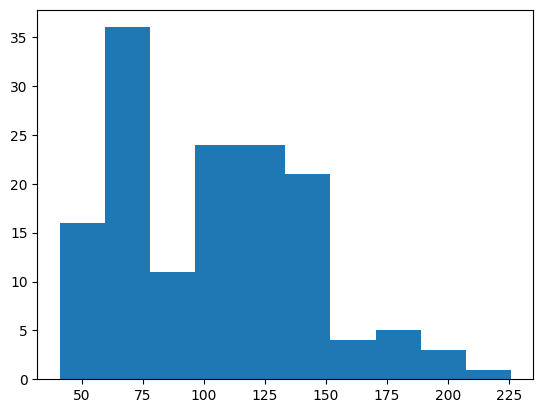

In [ ]:
fdata =fantasy_data.loc[:,"FPoints"]

plt.hist(fdata)
#heres our data shape. This is what I will use to base our distrobutions off of
#after looking at it initally it looks like a "normal" distrobution with a slight negative skew

now we are setting up the groups

In [ ]:
pos_idx = fantasy_data.Position.cat.codes.values
pos_codes = fantasy_data.Position.cat.categories
fantasy_coords = {"pos": pos_codes}
#indexing our data in order to create catagories

In [ ]:
fantasy_coords
#checking the catagories came out properly

{'pos': Index(['DEF', 'K', 'QB', 'RB', 'TE', 'WR'], dtype='object')}

and now with all my data indexing and stuff set up we can start to work on finding a likelihood/priors to use for our hyper priors

##Step 2 Finding Likelihoods/Priors

(array([16., 36., 11., 24., 24., 21.,  4.,  5.,  3.,  1.]),
 array([ 41.   ,  59.466,  77.932,  96.398, 114.864, 133.33 , 151.796,
        170.262, 188.728, 207.194, 225.66 ]),
 <BarContainer object of 10 artists>)

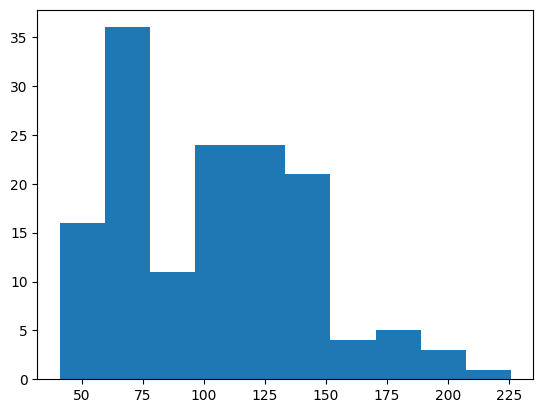

In [ ]:
#view of my data for me to refer to
fdata =fantasy_data.loc[:,"FPoints"]

plt.hist(fdata)

For this first attempt I am going to try to ignore the dip in the data around 80 points. I am assuming it is insignifigant untill the PPC says otherwise.

I am also going to use the average value of 133 to dictate where the center of the skewed graph is

<Axes: >

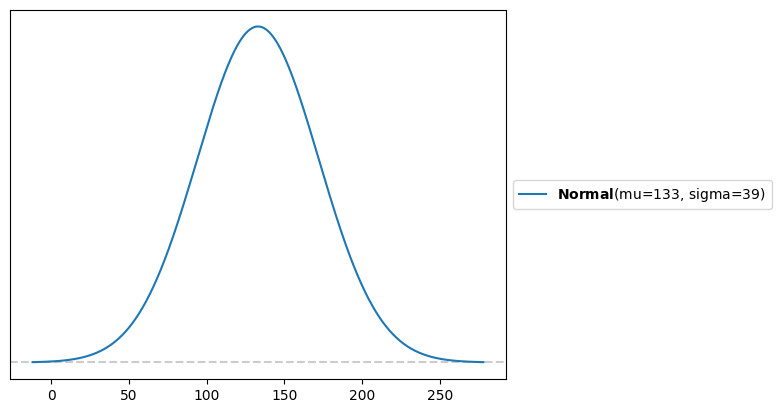

In [ ]:
#the data is continous so i am going to begin with a continous distrobution...in this case a normal
pz.Normal(mu= 133, sigma=39).plot_pdf()

<Axes: >

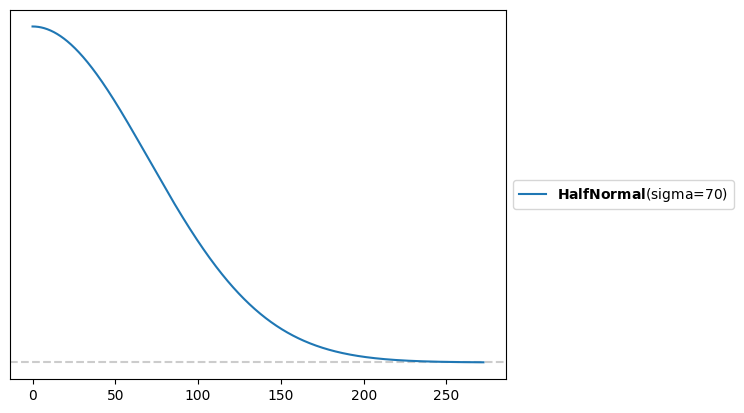

In [ ]:
#trying halfnormal per arredandandos recomendation
pz.HalfNormal(sigma= 70).plot_pdf()

<Axes: >

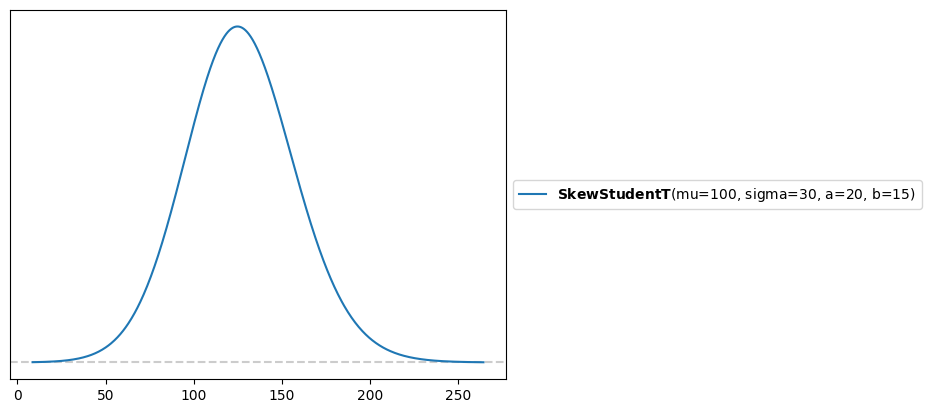

In [ ]:
pz.SkewStudentT(mu=100,sigma= 30, a=20, b=15).plot_pdf()
#I considered using this skew studentT, but decided against it because of its relatively complicated setup

##Running Attempt #1

In [ ]:
with pm.Model(coords = fantasy_coords) as fantasy_model:
    # Hyper parameters
    μ = pm.Normal('μ', mu= 133, sigma= 39)
    σ = pm.HalfNormal('σ', sigma=70)

    # Parameters for positions
    μ_p = pm.Normal('μ_p', mu = μ, sigma = σ, dims = "pos")

    σ_p = pm.HalfNormal('σ_p',sigma = 70, dims="pos")

   #Putting it all together with a normal distrobution

    Y= pm.Normal('Y', mu = μ_p[pos_idx], sigma = σ_p[pos_idx], observed=fdata)
    idata_FPointsNormal = pm.sample()

Output()

Output()

array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'σ_p'}>, <Axes: title={'center': 'σ_p'}>]],
      dtype=object)

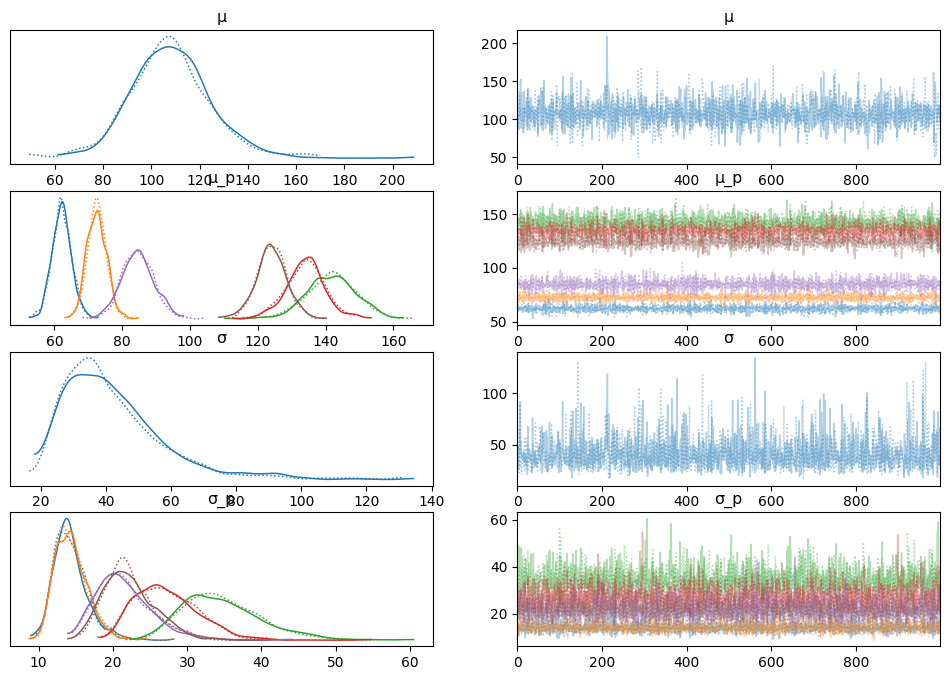

In [ ]:
az.plot_trace(idata_FPointsNormal)
#im doing some quick looking here befoe I run my ppc to see how the code seems to have "felt" about the information I gave it

In [ ]:
pm.sample_posterior_predictive(idata_FPointsNormal, model=fantasy_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

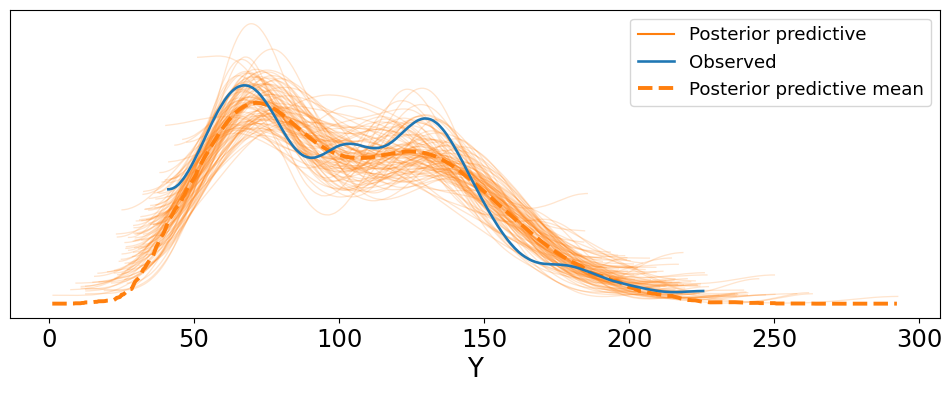

In [ ]:
az.plot_ppc(idata_FPointsNormal, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

A pretty solid first attempt!!! It mateches all of the strange newance prettey well, but there is room for improvement.

##Attempt #2

In [ ]:
with pm.Model(coords = fantasy_coords) as fantasy_model2:
    # Same hyper parameters as last time
    alpha_p = pm.Normal('alpha_p', mu= 133, sigma= 39)
    beta_p = pm.HalfNormal('beta_p', sigma=70)


    # Parameters for positions are the same aswell
    alpha = pm.Normal('alpha', mu = alpha_p, sigma = beta_p, dims = "pos")

    beta = pm.HalfNormal('beta',sigma = 70, dims="pos")

    # This time I am using a Gamma distrobution for my likelihood instead of a normal one

    Y= pm.Gamma('Y', alpha = alpha[pos_idx], beta = beta[pos_idx], observed=fdata)
    idata_FPointsGamma = pm.sample(target_accept = 0.95)
#had to add target accept to decrease divergences and I still have a couple

Output()

Output()

ERROR:pymc.stats.convergence:There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
pm.sample_posterior_predictive(idata_FPointsGamma, model=fantasy_model2, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

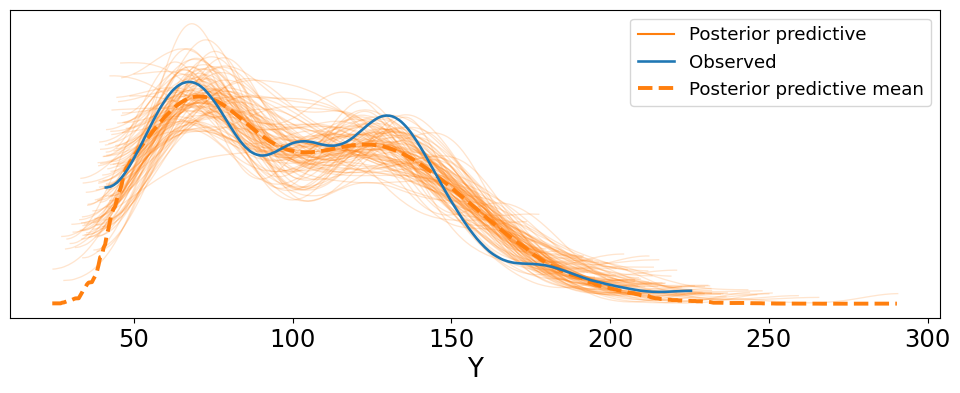

In [ ]:
az.plot_ppc(idata_FPointsGamma, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Wow!! That's definatley better. Im sure if I get a "lucky" run itll be almost identical, but I am going to call this good for now

##Analyzing Hierircal Model Vs Non Hierircal

Now im going to compare the Hierircal model to a non-Hierircal one to see if the Hyper-priors helped or hurt the data

In [ ]:
with pm.Model(coords = fantasy_coords) as fantasy_modelNHP:

    # Parameters for positions with NO Hyperpriors
    alpha = pm.Normal('alpha', mu = 133, sigma = 39, dims = "pos")

    beta = pm.HalfNormal('beta',sigma = 70, dims="pos")

    # Still using the Gamma becuase I am happy with how it went last time

    Y= pm.Gamma('Y', alpha = alpha[pos_idx], beta = beta[pos_idx], observed=fdata)
    idata_FPointsNHP = pm.sample(target_accept = 0.95)
                            #keeping the target accept value

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_FPointsNHP, model=fantasy_modelNHP, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

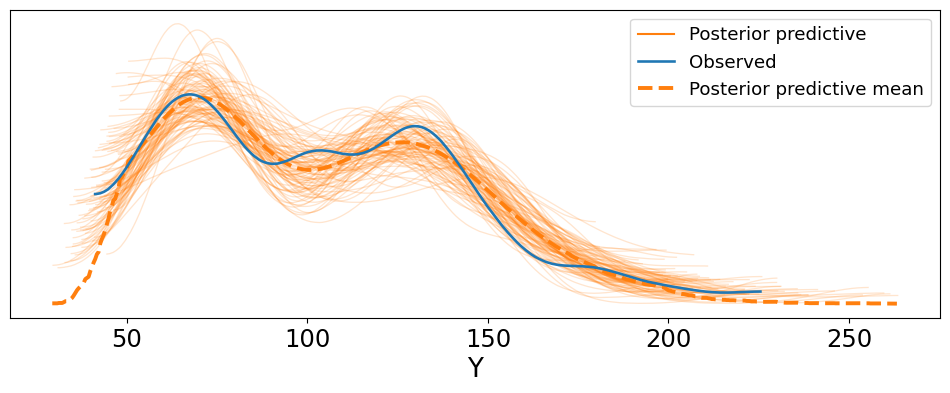

In [ ]:
az.plot_ppc(idata_FPointsNHP, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Dang! That might be the best one yet! Before I even look at the comparison I have a feeling that the non-hierical model will the better

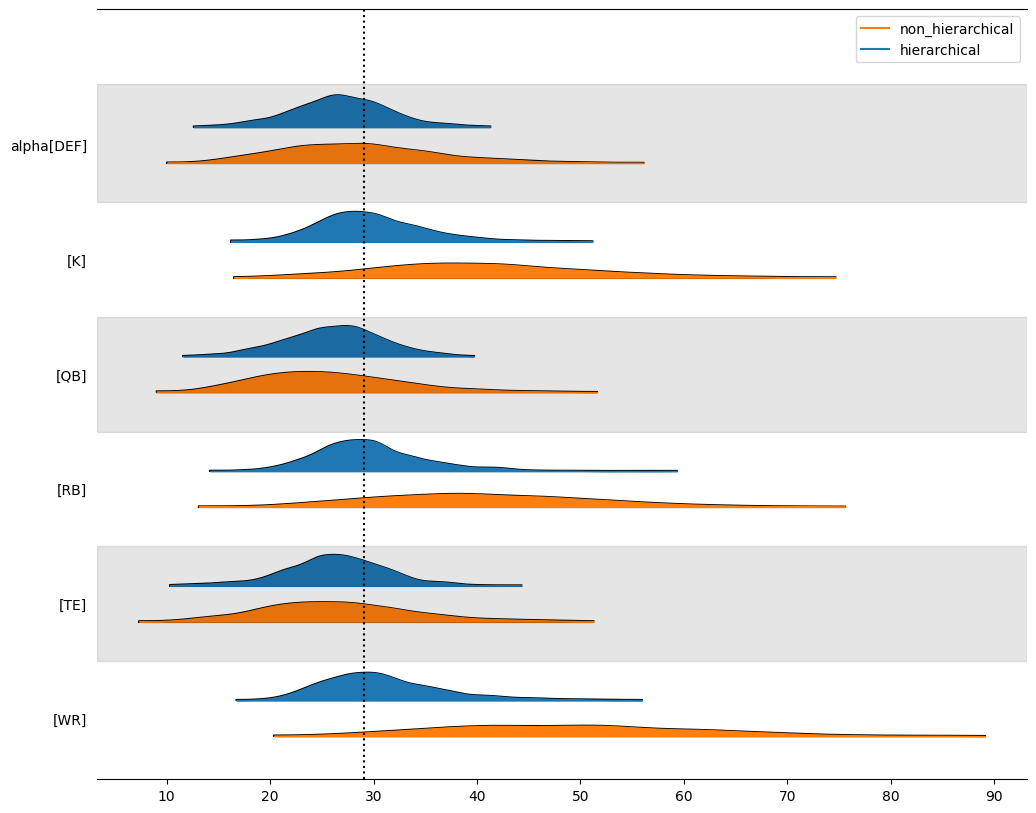

In [ ]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_FPointsGamma, idata_FPointsNHP], kind="ridgeplot",
                      model_names=['hierarchical', 'non_hierarchical'],
                      var_names='alpha', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_FPointsGamma.posterior['alpha_p'].mean(), *y_lims, color="k", ls=":");

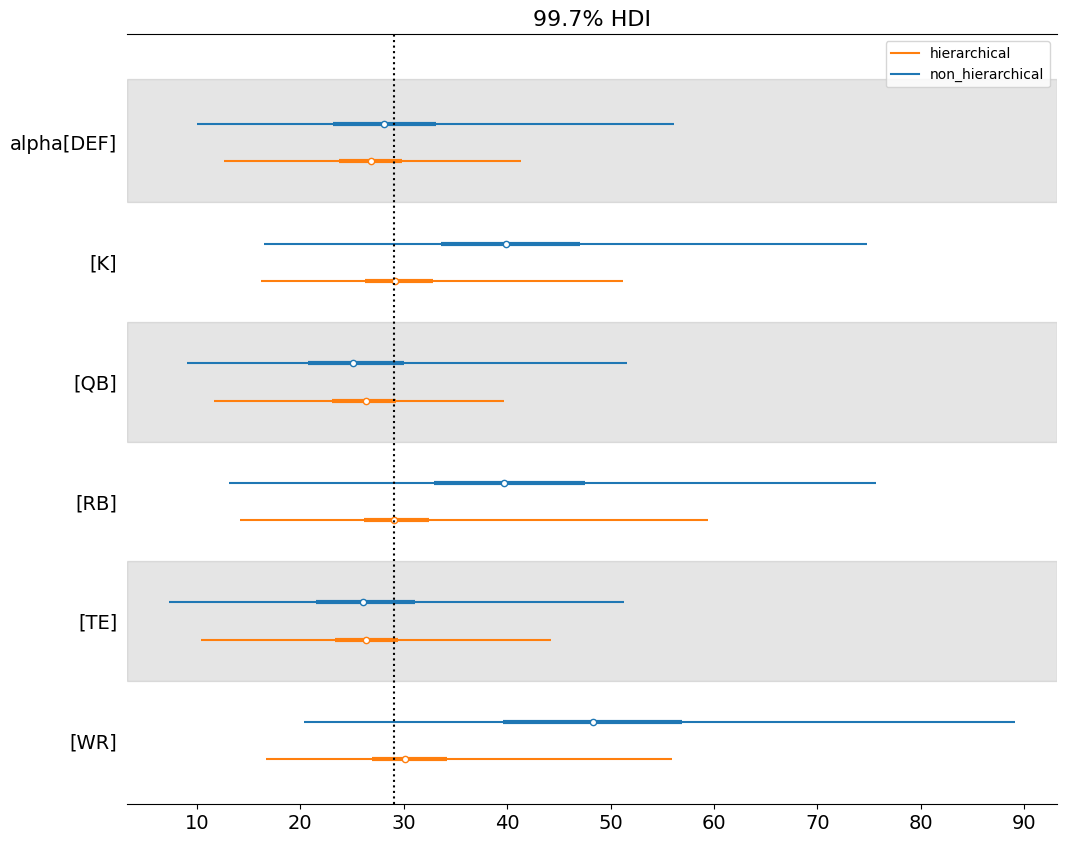

In [ ]:
#same as above, but a different type of plot
axes = az.plot_forest([idata_FPointsNHP, idata_FPointsGamma], kind="forestplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names='alpha', combined=True, figsize=(12, 10),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_FPointsGamma.posterior['alpha_p'].mean(), *y_lims, color="k", ls=":");

## Conclusion

What I find the most intresting after looking at the PPC for the non-Hierircal model and now the comparison plots for the two models is that even though the PPC looked better on the non-Hierircal one the shrinkage on the Hierircal model actually helpt a whole lot to consolidate the data into something that shows the averages better. BUT at the sacrifice of hiding the story of how inconsistent some positions are over others as far as average points go.


### Application to me
This data did not tell me a lot of new things about fantasy football, but it did help me visulize consistencies between players. It also shows me that certian positions, like kickers, are actually pretty important because a good one can be way more consistent at putting up points (albeit less points, but it does add up)